In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import os

C:\Users\NCN\AppData\Local\Temp\ipykernel_13032\1700648380.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [2]:
# dataloader arguments
batch_size = 128
data_path=r"C:\Users\NCN\Documents\PedroFelix\LAVA_SNN_ripples\extract_Nripples\train_pedro\n_dataset\up_down"
bandpass=[100,250]
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
positives = np.load(os.path.join(data_path,f"ntrue_positives_{bandpass[0]}_{bandpass[1]}Hz.npy"))
negatives = np.load(os.path.join(data_path,f"ntrue_negatives_{bandpass[0]}_{bandpass[1]}Hz.npy"))

In [4]:
positives_tensor = torch.tensor(positives, dtype=torch.float32)
negatives_tensor = torch.tensor(negatives, dtype=torch.float32)
print(positives_tensor.shape, negatives_tensor.shape)

torch.Size([1794, 2, 246]) torch.Size([1800, 2, 246])


In [5]:
from torch.utils.data import DataLoader, TensorDataset,random_split




# Combine the data (positive and negative) into one dataset
X = torch.cat((positives_tensor, negatives_tensor), dim=0)

# Fixed version:
y = torch.cat((torch.ones(positives_tensor.shape[0], dtype=torch.long),  # Note dtype
               torch.zeros(negatives_tensor.shape[0], dtype=torch.long)), dim=0)

# Create a TensorDataset
dataset = TensorDataset(X, y)

# Define split ratios
test_ratio = 0.1  # 10% for testing
train_ratio = 1 - test_ratio

# Calculate split sizes
num_samples = len(dataset)
train_size = int(train_ratio * num_samples)
test_size = num_samples - train_size

# Split the dataset
train_dataset, test_dataset = random_split(
    dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # important for training
    drop_last=True  # drops last incomplete batch
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # no need to shuffle test data
    drop_last=False  # we want all test samples
)


 # Define the Network


In [6]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = positives.shape[2]

In [7]:
#  Initialize Network
# Note: the following code-block simulates over one single time-step, and requires a separate for-loop over time.
input_size=2
num_classes=2
net = nn.Sequential(nn.Linear(input_size, 256),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Linear(256, 64),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Linear(64, num_classes),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)



In [8]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    current_data = data[:, :, step]
    spk_out, mem_out = net(current_data)

In [9]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      curr = data[:, :, step]
      spk_out, mem_out = net(curr)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)
  
  return torch.stack(spk_rec, dim=0), torch.stack(mem_rec,dim=0)

In [10]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

In [11]:
# already imported snntorch.functional as SF 
loss_fn = SF.ce_rate_loss()
loss_val = loss_fn(spk_rec, targets)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 0.693


In [12]:
acc = SF.accuracy_rate(spk_rec, targets)
print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 48.438%


In [13]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()
    
    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

# Training Loop


In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 10
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
          with torch.no_grad():
              net.eval()
              # Test set forward pass
              test_acc = batch_accuracy(test_loader, net, num_steps)
              print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
              test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 46.94%

Iteration 50, Test Acc: 83.33%

Iteration 100, Test Acc: 85.28%

Iteration 150, Test Acc: 86.39%

Iteration 200, Test Acc: 85.83%



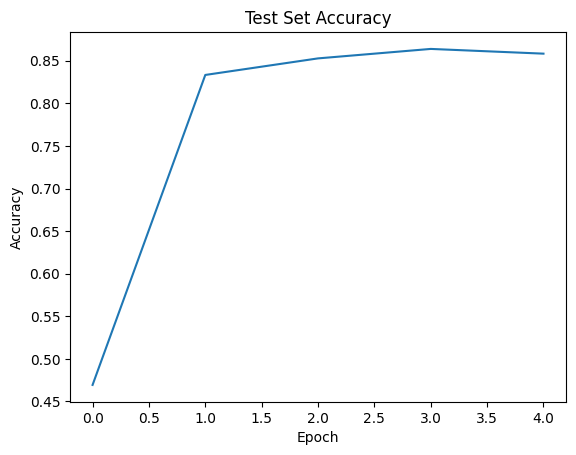

In [15]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

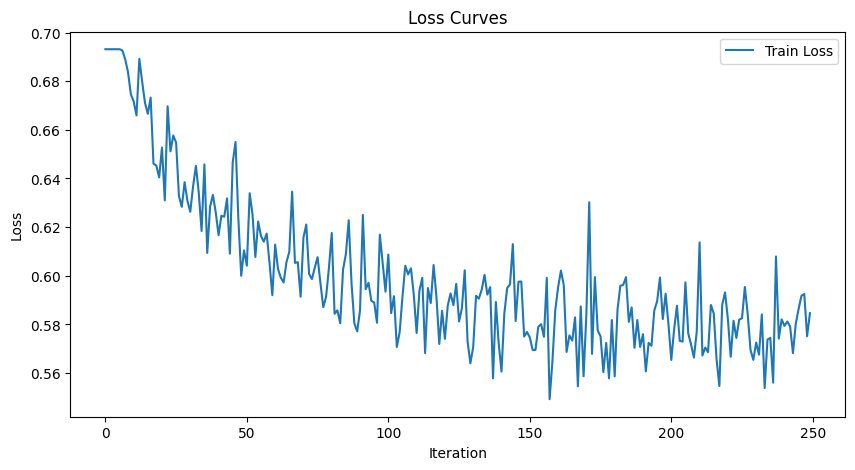

In [16]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
# plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [17]:
def evaluate_acc(model, test_loader, num_steps):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            # Forward pass
            spk_rec, _ = forward_pass(model, num_steps, data)
            
            # Calculate accuracy
            acc = SF.accuracy_rate(spk_rec, targets)
            total_correct += acc * targets.size(0)
            total_samples += targets.size(0)
    
    final_acc = total_correct / total_samples
    print(f"Final Test Accuracy: {final_acc*100:.2f}%")
    return final_acc

# Run evaluation
final_accuracy = evaluate_acc(net, test_loader, num_steps)

Final Test Accuracy: 85.83%


In [18]:
def evaluate_model(model, loader, num_steps):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            
            # Forward pass
            spk_rec, _ = forward_pass(model, num_steps, data)
            
            # Sum spikes over time and get predictions
            preds = spk_rec.sum(dim=0).argmax(dim=1)  # shape: [batch_size]
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return np.array(all_preds), np.array(all_targets)

# Get predictions for entire test set
y_pred, y_true = evaluate_model(net, test_loader, num_steps)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Precision: 0.9667
Recall: 0.7592
F1 Score: 0.8504


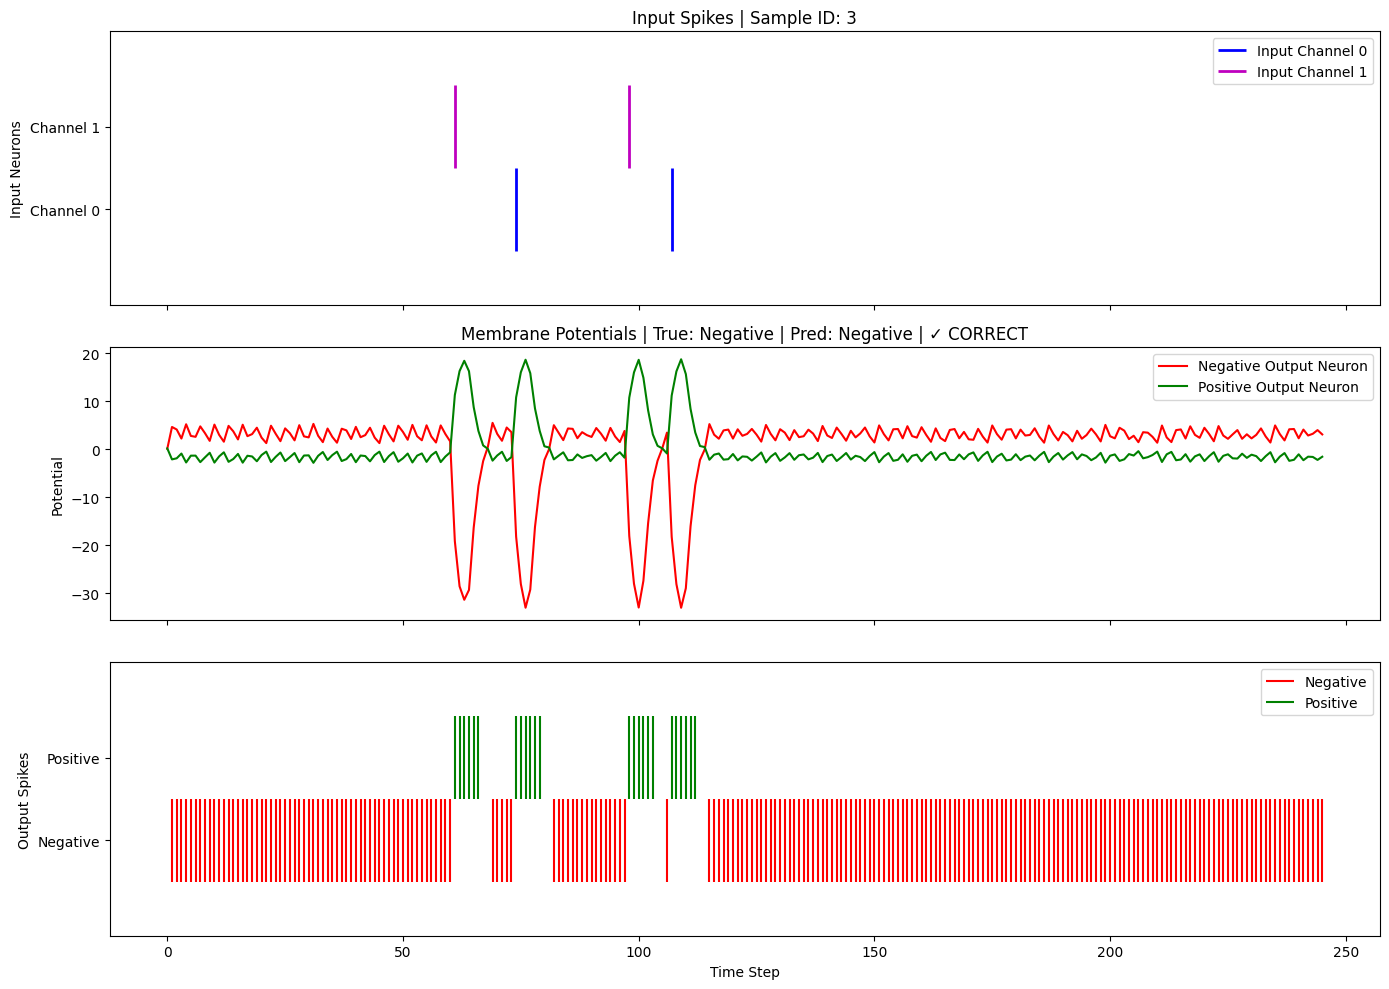

Sample 3 | True: Negative | Predicted: Negative
Spike counts - Negative: 213.0, Positive: 24.0
Classification: ✓ CORRECT


In [20]:
def plot_sample_spikes(model, sample_data, true_label, num_steps, id=0):
    model.eval()
    
    # Select specific sample
    sample_data = sample_data[id]
    true_label = true_label[id]
    
    with torch.no_grad():
        spk_rec, mem_rec = forward_pass(model, num_steps, sample_data.unsqueeze(0))  # Add batch dim

    # Convert true_label to Python scalar
    true_label = true_label.item() if torch.is_tensor(true_label) else true_label
    
    # Get predictions
    total_spikes = spk_rec.sum(dim=0)  # shape: [1, 2]
    neg_spikes = total_spikes[0, 0].item()  # Negative class
    pos_spikes = total_spikes[0, 1].item()  # Positive class
    
    predicted_class = 1 if pos_spikes > neg_spikes else 0
    true_label_str = "Positive" if true_label else "Negative"
    pred_label_str = "Positive" if predicted_class else "Negative"
    correct_str = "✓ CORRECT" if predicted_class == true_label else "✗ WRONG"

    # Create figure with 3 subplots
    fig,axes=plt.subplots(3,1,figsize=(14, 10),sharex=True)
    
    # 1. Input Spikes (assuming 2 input channels)
    ax=axes[0]
    for i in range(2):  # For each input channel
        spikes = sample_data[i].cpu().nonzero()[:, 0].numpy()
        ax.eventplot(spikes, lineoffsets=i, colors=['b', 'm'][i], 
                     linewidths=2, label=f"Input Channel {i}")
    ax.set_yticks([0, 1], ["Channel 0", "Channel 1"])
    ax.set_title(f"Input Spikes | Sample ID: {id}")
    ax.set_ylabel("Input Neurons")
    ax.legend()

    # 2. Membrane Potentials
    ax=axes[1]
    ax.plot(mem_rec[:, 0, 0].cpu(), 'r', label="Negative Output Neuron")
    ax.plot(mem_rec[:, 0, 1].cpu(), 'g', label="Positive Output Neuron")
    ax.set_title(f"Membrane Potentials | True: {true_label_str} | Pred: {pred_label_str} | {correct_str}")
    ax.set_ylabel("Potential")
    ax.legend()

    # 3. Output Spikes
    ax=axes[2]
    ax.eventplot(spk_rec[:, 0, 0].cpu().nonzero()[:, 0].numpy(), 
                 lineoffsets=0, colors='r', label="Negative")
    ax.eventplot(spk_rec[:, 0, 1].cpu().nonzero()[:, 0].numpy(),
                 lineoffsets=1, colors='g', label="Positive")
    ax.set_yticks([0, 1], ["Negative", "Positive"])
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Output Spikes")
    ax.legend()
    
    plt.tight_layout()
    plt.show()

    print(f"Sample {id} | True: {true_label_str} | Predicted: {pred_label_str}")
    print(f"Spike counts - Negative: {neg_spikes:.1f}, Positive: {pos_spikes:.1f}")
    print(f"Classification: {correct_str}")

# Usage
sample_data, true_label = next(iter(test_loader))
plot_sample_spikes(net, sample_data, true_label, num_steps, id=3)  # Visualize sample 1

In [ ]:
# def plot_sample_spikes(model, test_loader, num_steps, sample_idx=None):
#     """Visualize spikes and membrane potentials with class-specific outputs."""
#     # Get sample
#     test_data = test_loader.dataset
#     if sample_idx is None:
#         sample_idx = torch.randint(0, len(test_data), (1,)).item()
    
#     sample_data, true_label = test_data[sample_idx]
#     sample_data = sample_data.to(device).unsqueeze(0)  # add batch dim

#     # Forward pass
#     model.eval()
#     with torch.no_grad():
#         spk_rec, mem_rec = forward_pass(model, num_steps, sample_data)
    
#     # Prediction (which neuron spiked more)
#     spike_counts = spk_rec.sum(0).squeeze()  # sum over time [2]
#     predicted_label = spike_counts.argmax().item()
#     confidence = spike_counts / spike_counts.sum()  # normalized firing rates

#     # Create figure
#     fig = plt.figure(figsize=(16, 10))
#     gs = fig.add_gridspec(3, 2)
    
#     # Membrane potentials (one subplot per output neuron)
#     ax1 = fig.add_subplot(gs[0, 0])
#     ax1.plot(mem_rec[:, 0, 0].cpu(), 'r', label="Negative Class Neuron")
#     ax1.set_title(f"Negative Class Output (True: {'Positive' if true_label else 'Negative'})")
#     ax1.set_ylabel("Membrane Potential")
#     ax1.legend()
    
#     ax2 = fig.add_subplot(gs[0, 1])
#     ax2.plot(mem_rec[:, 0, 1].cpu(), 'g', label="Positive Class Neuron")
#     ax2.set_title(f"Positive Class Output (Predicted: {'Positive' if predicted_label else 'Negative'})")
#     ax2.legend()

#     # Output spikes (raster plot)
#     ax3 = fig.add_subplot(gs[1, :])
#     for i in range(2):  # for each output neuron
#         spikes = spk_rec[:, 0, i].cpu().nonzero()[:, 0].numpy()
#         ax3.eventplot(spikes, lineoffsets=i+1, colors=['r', 'g'][i], linewidths=2)
#     ax3.set_yticks([1, 2], ["Negative Neuron", "Positive Neuron"])
#     ax3.set_title(f"Output Spikes | Confidence: {confidence[0]:.2f}/{confidence[1]:.2f}")
#     ax3.set_ylabel("Output Neurons")

#     # Input spikes
#     ax4 = fig.add_subplot(gs[2, :])
#     for i in range(2):  # up/down channels
#         spikes = sample_data[0, i].cpu().nonzero()[:, 0].numpy()
#         ax4.eventplot(spikes, lineoffsets=i+1, colors=['b', 'm'][i], linewidths=1)
#     ax4.set_yticks([1, 2], ["Input Down", "Input Up"])
#     ax4.set_xlabel("Time Step")
#     ax4.set_ylabel("Input Spikes")

#     plt.suptitle(f"Sample {sample_idx} | "
#                 f"True: {'Positive' if true_label else 'Negative'} | "
#                 f"Predicted: {'Positive' if predicted_label else 'Negative'} | "
#                 f"{'CORRECT' if true_label == predicted_label else 'WRONG'}", 
#                 fontsize=14, y=1.02)
#     plt.tight_layout()
#     plt.show()

#     return sample_idx

# # Interactive usage:
# def explore_samples(model, test_loader, num_steps):
#     """Interactive sample explorer."""
#     current_idx = 0
#     total_samples = len(test_loader.dataset)
    
#     while True:
#         print(f"\nSample {current_idx}/{total_samples-1}")
#         current_idx = plot_sample_spikes(model, test_loader, num_steps, current_idx)
        
#         user_input = input("Next [n], Previous [p], Jump to index [0-9], Quit [q]: ")
#         if user_input.lower() == 'n':
#             current_idx = (current_idx + 1) % total_samples
#         elif user_input.lower() == 'p':
#             current_idx = (current_idx - 1) % total_samples
#         elif user_input.isdigit():
#             new_idx = int(user_input)
#             if 0 <= new_idx < total_samples:
#                 current_idx = new_idx
#         elif user_input.lower() == 'q':
#             break

# # Usage:
# explore_samples(net, test_loader, num_steps)

In [ ]:
# Saving
# def save_model(model, optimizer, path, extra_info=None):
#     save_dict = {
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'model_params': {
#             'input_size': 2,
#             'num_classes': 2,
#             'beta': beta,
#         }
#     }
#     if extra_info:
#         save_dict.update(extra_info)
#     torch.save(save_dict, path)

# # Example usage
# save_model(net, optimizer, 'snn_checkpoint.pth', 
#           {'loss_hist': loss_hist, 'test_acc': test_acc_hist})